In [1]:
import os
from rdkit import Chem
from rdkit import RDPaths
import numpy as np

import torch
import dgl
if torch.cuda.is_available():
    print('use GPU')
    device='cuda'
else:
    print('use CPU')
    device='cpu'

from dgl.model_zoo.chem import GCNClassifier
from dgl.data.chem.utils import mol_to_graph
from dgl.data.chem.utils import mol_to_complete_graph
from dgl.data.chem import CanonicalAtomFeaturizer
from dgl.data.chem import CanonicalBondFeaturizer
from torch import nn

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss

RDKit WARNING: [16:00:50] Enabling RDKit 2019.09.3 jupyter extensions


use GPU


In [2]:
trainsdf = os.path.join(RDPaths.RDDocsDir, 'Book/data/solubility.train.sdf')
testsdf =  os.path.join(RDPaths.RDDocsDir, 'Book/data/solubility.test.sdf')

trainmols = [m for m in Chem.SDMolSupplier(trainsdf)]
testmols = [m for m in Chem.SDMolSupplier(testsdf)]

prop_dict = {
    "(A) low": 0,
    "(B) medium": 1,
    "(C) high": 2
}


In [3]:
atom_featurizer = CanonicalAtomFeaturizer()
bond_featurizer = CanonicalBondFeaturizer()

In [4]:
g = mol_to_complete_graph(trainmols[0], 
                          add_self_loop=False, 
                          node_featurizer=atom_featurizer,
                          #edge_featurizer= bond_featurizer
                         )

In [5]:
# check feature size
n_feats = atom_featurizer.feat_size('h')
print(n_feats)

74


In [6]:
ncls = 3


train_g = [mol_to_complete_graph(m, node_featurizer=atom_featurizer) for m in trainmols]
train_y = np.array([prop_dict[m.GetProp('SOL_classification')] for m in trainmols])
train_y = np.array(train_y, dtype=np.int64)

test_g = [mol_to_complete_graph(m, node_featurizer=atom_featurizer) for m in testmols]
test_y = np.array([prop_dict[m.GetProp('SOL_classification')] for m in testmols])
test_y = np.array(test_y, dtype=np.int64)


In [7]:
# define GCN NET with 2 GCN layers
gcn_net = GCNClassifier(in_feats=n_feats,
                    gcn_hidden_feats=[60,20],
                    n_tasks=ncls,
                    classifier_hidden_feats=10,
                    dropout=0.5,)
gcn_net = gcn_net.to(device)

In [8]:
def collate(sample):
    graphs, labels = map(list,zip(*sample))
    batched_graph = dgl.batch(graphs)
    batched_graph.set_n_initializer(dgl.init.zero_initializer)
    batched_graph.set_e_initializer(dgl.init.zero_initializer)
    return batched_graph, torch.tensor(labels)

In [9]:
train_data = list(zip(train_g, train_y))
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=collate, drop_last=True)

In [10]:
loss_fn = CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn_net.parameters(), lr=0.01)
gcn_net.train()

GCNClassifier(
  (gnn_layers): ModuleList(
    (0): GCNLayer(
      (graph_conv): GraphConv(in=74, out=60, normalization=False, activation=<function relu at 0x7efbaf93f1e0>)
      (dropout): Dropout(p=0.0, inplace=False)
      (res_connection): Linear(in_features=74, out_features=60, bias=True)
      (bn_layer): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): GCNLayer(
      (graph_conv): GraphConv(in=60, out=20, normalization=False, activation=<function relu at 0x7efbaf93f1e0>)
      (dropout): Dropout(p=0.0, inplace=False)
      (res_connection): Linear(in_features=60, out_features=20, bias=True)
      (bn_layer): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (weighted_sum_readout): WeightAndSum(
    (atom_weighting): Sequential(
      (0): Linear(in_features=20, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (soft_classifier): MLPBinaryClassifier(
    (predict): Sequential(
    

In [11]:
epoch_losses = []
epoch_accuracies = []
for epoch in range(1,201):
    epoch_loss = 0
    epoch_acc = 0
    for i, (bg, labels) in enumerate(train_loader):
        labels = labels.to(device)
        atom_feats = bg.ndata.pop('h').to(device)
        atom_feats, labels = atom_feats.to(device), labels.to(device)
        pred = gcn_net(bg, atom_feats)
        loss = loss_fn(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        pred_cls = pred.argmax(-1).detach().to('cpu').numpy()
        true_label = labels.to('cpu').numpy()
        epoch_acc += sum(true_label==pred_cls) / true_label.shape[0]
    epoch_acc /= (i + 1)
    epoch_loss /= (i + 1)
    if epoch % 20 == 0:
        print(f"epoch: {epoch}, LOSS: {epoch_loss:.3f}, ACC: {epoch_acc:.3f}")
    epoch_accuracies.append(epoch_acc)
    epoch_losses.append(epoch_loss)

epoch: 20, LOSS: 0.384, ACC: 0.834
epoch: 40, LOSS: 0.327, ACC: 0.842
epoch: 60, LOSS: 0.290, ACC: 0.874
epoch: 80, LOSS: 0.257, ACC: 0.893
epoch: 100, LOSS: 0.244, ACC: 0.896
epoch: 120, LOSS: 0.249, ACC: 0.899
epoch: 140, LOSS: 0.222, ACC: 0.903
epoch: 160, LOSS: 0.186, ACC: 0.928
epoch: 180, LOSS: 0.158, ACC: 0.941
epoch: 200, LOSS: 0.178, ACC: 0.928


Text(0, 0.5, 'loss/acc')

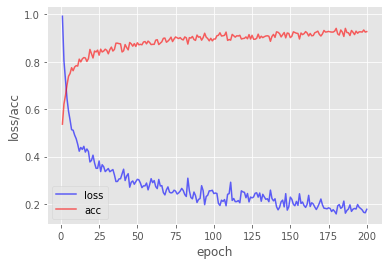

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot([i for i in range(1, 201)], epoch_losses, c='b', alpha=0.6, label='loss')
plt.legend()
plt.plot([i for i in range(1, 201)], epoch_accuracies, c='r', alpha=0.6, label='acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss/acc')